
# Wine Quality Classification — From Scratch (LR & SVM + Kernels)

**Date:** 2025-10-07 08:16  
**Author:** Antonella Convertini

Requirements:

- **Models from scratch:** Logistic Regression (LR) and Support Vector Machine (SVM).  
- **Kernel methods:** Kernelized SVM (RBF, Polynomial) and Kernelized Logistic Regression (RBF, Polynomial).  
- **Data:** UCI Wine Quality (red + white), binary label _good_ (quality ≥ 6) vs _bad_ (quality < 6).  
- **Important:** The dataset is **unbalanced**; **`type`** (red/white) is **used for EDA only** and **not** for modeling.  
- **Preprocessing:** Robust pipeline with **Z-score outlier diagnostics** + **IQR Winsorization** (capping).  
- **Validation:** No leakage. **5-fold Stratified CV** and **automatic grid search** for hyperparameters.  
- **Metrics & Plots:** Accuracy, Precision, Recall, F1, confusion matrix, loss curves, learning curves; misclassification analysis.
- **Reproducibility:** Single-run `main()` orchestrates the complete workflow.

> ⚠️ _Note_: This notebook uses only `numpy`, `pandas`, `matplotlib`, `seaborn` for utilities.  
> No scikit-learn models are used; a minimal CV and scaler are implemented here to avoid dependencies.


In [ ]:
# Imports & Settings
import os
import io
import json
import math
import time
import copy
import random
import warnings
from dataclasses import dataclass
from typing import Tuple, List, Dict, Callable

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore")
np.set_printoptions(suppress=True, precision=6)
RANDOM_STATE = 42

# Matplotlib defaults
plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["axes.grid"] = True
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False

def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)

set_seed(RANDOM_STATE)



## Utilities: metrics, scaler, stratified splits, plotting
Implement basic metrics and a minimal stratified K-fold without scikit-learn.


In [ ]:
# Metrics
def accuracy_score(y_true, y_pred):
    y_true = np.asarray(y_true).astype(int)
    y_pred = np.asarray(y_pred).astype(int)
    return (y_true == y_pred).mean()

def precision_score(y_true, y_pred, eps=1e-12):
    y_true = np.asarray(y_true).astype(int)
    y_pred = np.asarray(y_pred).astype(int)
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    return tp / (tp + fp + eps)

def recall_score(y_true, y_pred, eps=1e-12):
    y_true = np.asarray(y_true).astype(int)
    y_pred = np.asarray(y_pred).astype(int)
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    return tp / (tp + fn + eps)

def f1_score(y_true, y_pred, eps=1e-12):
    p = precision_score(y_true, y_pred, eps)
    r = recall_score(y_true, y_pred, eps)
    return 2 * p * r / (p + r + eps)

def confusion_matrix(y_true, y_pred):
    y_true = np.asarray(y_true).astype(int)
    y_pred = np.asarray(y_pred).astype(int)
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    tp = np.sum((y_true == 1) & (y_pred == 1))
    return np.array([[tn, fp], [fn, tp]])

def plot_confusion_matrix(cm, labels=("Bad(0)", "Good(1)"), title="Confusion Matrix"):
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels, ax=ax)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_title(title)
    plt.show()


In [ ]:
# Scaler (no leakage)
class StandardScaler:
    def __init__(self):
        self.mean_ = None
        self.std_ = None

    def fit(self, X):
        X = np.asarray(X, dtype=float)
        self.mean_ = X.mean(axis=0)
        self.std_ = X.std(axis=0, ddof=0)
        self.std_[self.std_ == 0] = 1.0
        return self

    def transform(self, X):
        X = np.asarray(X, dtype=float)
        return (X - self.mean_) / self.std_

    def fit_transform(self, X):
        return self.fit(X).transform(X)


In [ ]:
# Train/Test split (stratified)
def train_test_split_stratified(X, y, test_size=0.2, random_state=42):
    set_seed(random_state)
    X = np.asarray(X)
    y = np.asarray(y).astype(int)

    idx_pos = np.where(y == 1)[0]
    idx_neg = np.where(y == 0)[0]

    np.random.shuffle(idx_pos)
    np.random.shuffle(idx_neg)

    n_pos_test = int(len(idx_pos) * test_size)
    n_neg_test = int(len(idx_neg) * test_size)

    test_idx = np.concatenate([idx_pos[:n_pos_test], idx_neg[:n_neg_test]])
    train_idx = np.concatenate([idx_pos[n_pos_test:], idx_neg[n_neg_test:]])

    np.random.shuffle(train_idx)
    np.random.shuffle(test_idx)

    return X[train_idx], X[test_idx], y[train_idx], y[test_idx]

# Stratified K-Fold
def stratified_kfold_indices(y, n_splits=5, shuffle=True, random_state=42):
    set_seed(random_state)
    y = np.asarray(y).astype(int)
    idx_pos = np.where(y == 1)[0].tolist()
    idx_neg = np.where(y == 0)[0].tolist()

    if shuffle:
        np.random.shuffle(idx_pos)
        np.random.shuffle(idx_neg)

    pos_folds = np.array_split(idx_pos, n_splits)
    neg_folds = np.array_split(idx_neg, n_splits)

    folds = []
    for k in range(n_splits):
        test_idx = np.concatenate([pos_folds[k], neg_folds[k]])
        train_idx = np.setdiff1d(np.arange(len(y)), test_idx, assume_unique=False)
        folds.append((train_idx, test_idx))
    return folds



## Data Loading
Expect two CSV files from UCI (red + white). If files are not present locally, the code can try to download them (you can run locally with internet access).  
Create a `type` column (red/white) for **EDA only** and never use it for modeling.


In [ ]:
# Data Loading helpers
def load_wine_quality_local_or_download(data_dir="./data"):
    os.makedirs(data_dir, exist_ok=True)
    red_path = os.path.join(data_dir, "winequality-red.csv")
    white_path = os.path.join(data_dir, "winequality-white.csv")

    # If running locally, uncomment the downloader
    if not (os.path.exists(red_path) and os.path.exists(white_path)):
        try:
            import urllib.request
            # UCI mirror URLs (commonly used)
            url_red = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
            url_white = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv"
            urllib.request.urlretrieve(url_red, red_path)
            urllib.request.urlretrieve(url_white, white_path)
            print("Downloaded CSVs from UCI.")
        except Exception as e:
            print("Could not download from the internet. Please place the CSVs in", data_dir)
            print("Expected files: winequality-red.csv, winequality-white.csv")
            raise e

    red = pd.read_csv(red_path, sep=';')
    white = pd.read_csv(white_path, sep=';')
    red["type"] = "red"
    white["type"] = "white"
    df = pd.concat([red, white], axis=0, ignore_index=True)
    return df

# Try default local path in /mnt/data if present
default_dir = "/mnt/data"
try:
    df = load_wine_quality_local_or_download(default_dir)
except Exception:
    # fallback to ./data path (for local runs on your machine)
    df = load_wine_quality_local_or_download("./data")

print(df.shape)
df.head()


(6497, 13)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red



## Exploratory Data Analysis (EDA)

- Combine red & white; inspect shape, dtypes, missingness, duplicates.  
- Inspect distribution of `quality` and **binary target**: `good = 1 if quality ≥ 6 else 0`.  
- **Important:** `type` (red/white) is used for **EDA only** (imbalance reason).  
- Plot histograms, boxplots (by type), correlation heatmap.


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type,target
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,red,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,red,0


Shape: (6497, 14)
Columns: ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality', 'type', 'target']
Nulls per column:
 fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
type                    0
target                  0
dtype: int64
Duplicates: 1177


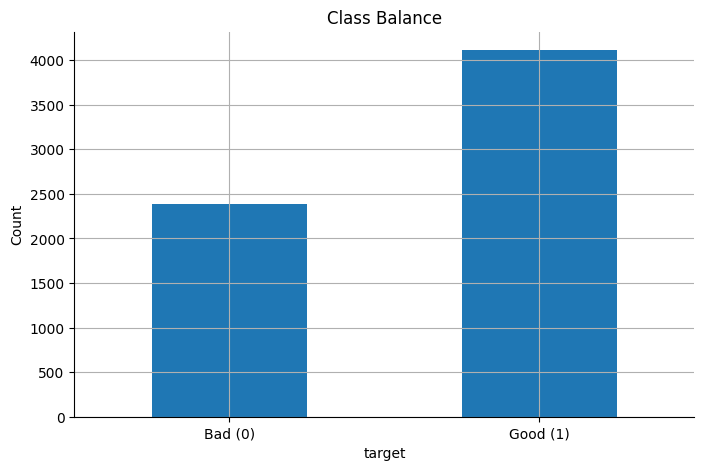

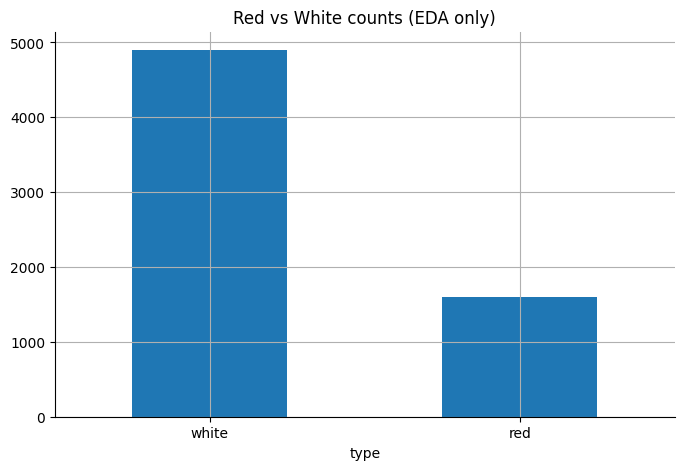

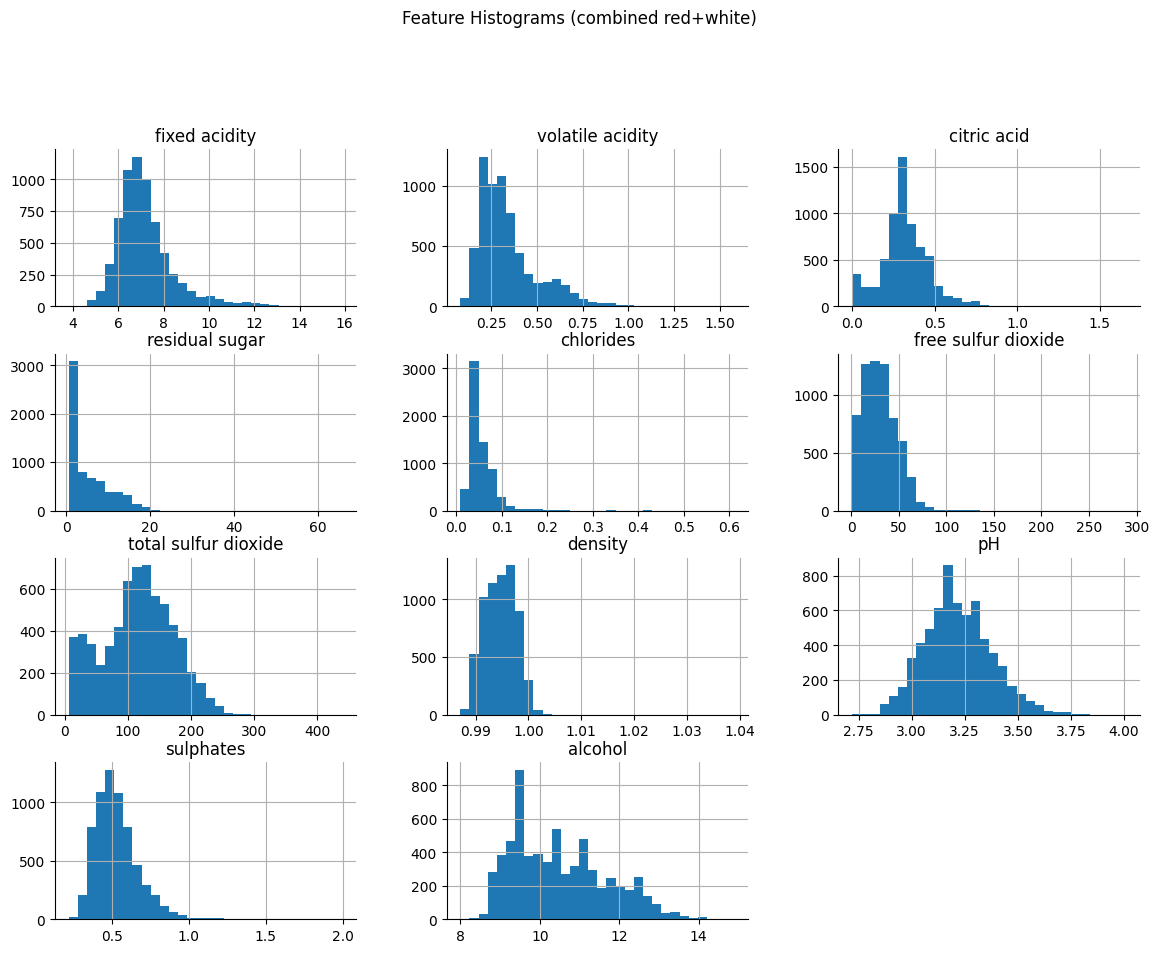

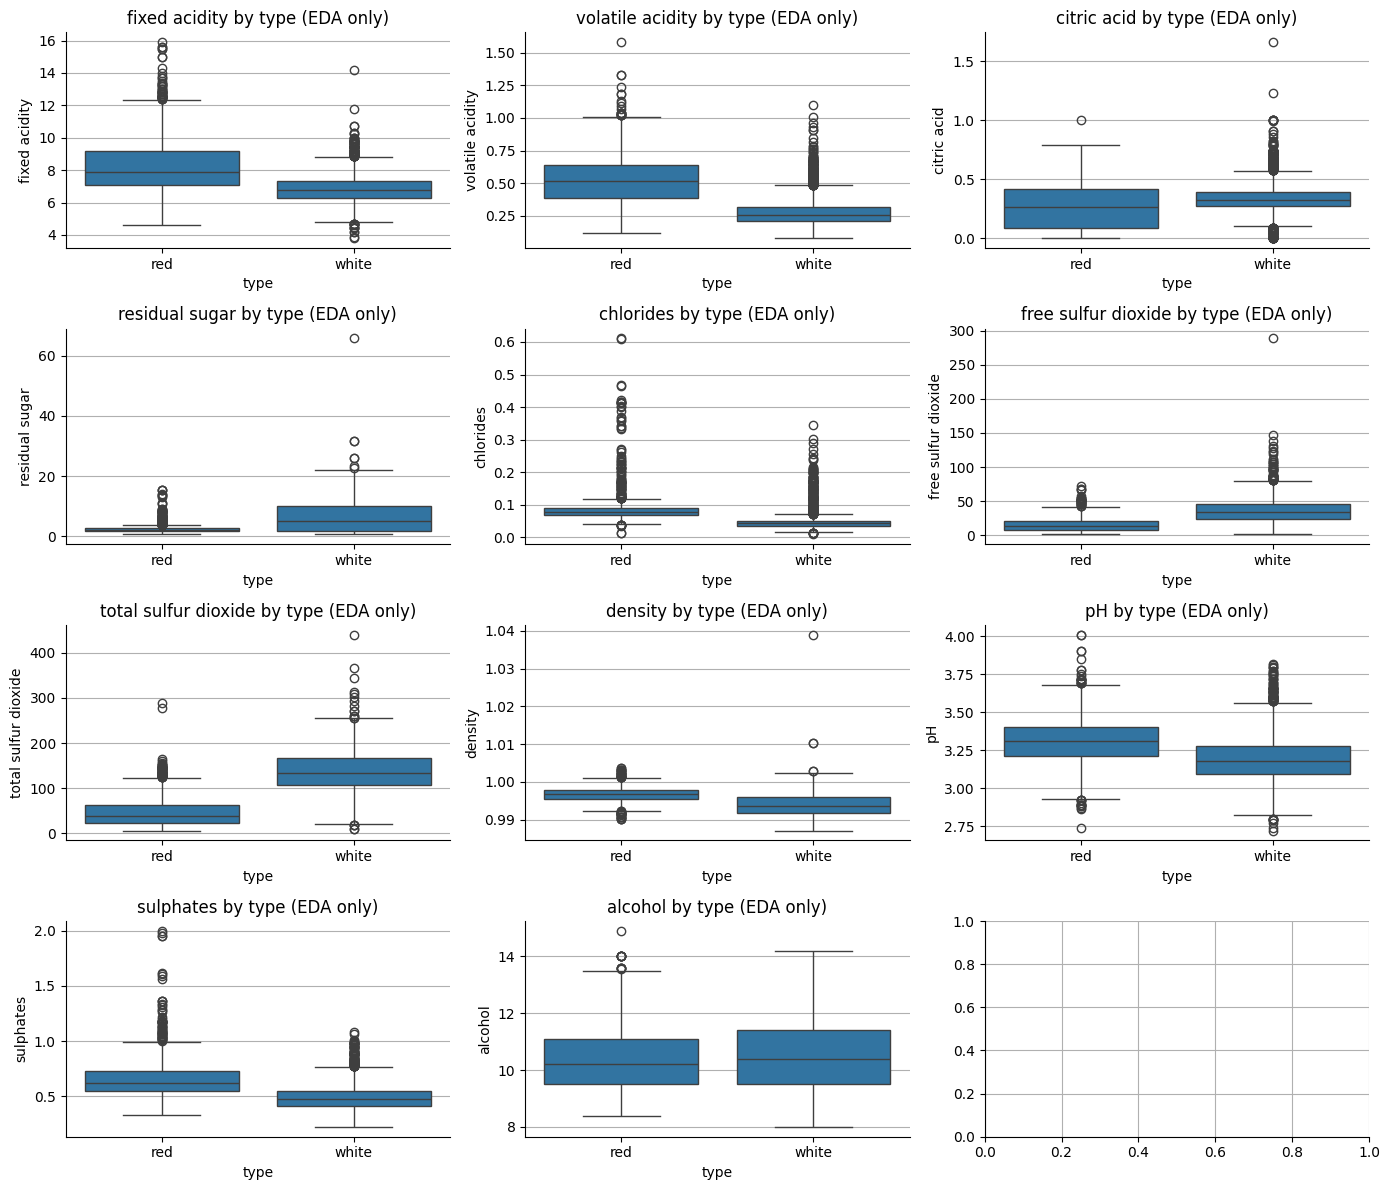

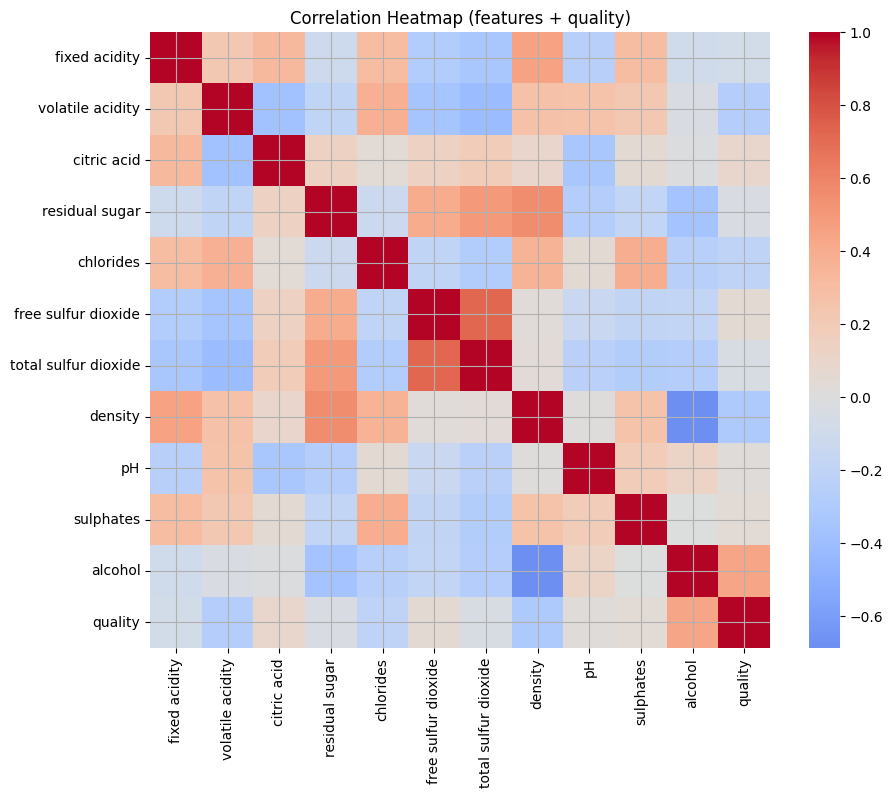

In [ ]:
# Target engineering (binary): good (1) if quality >= 6 else 0
df = df.copy()
df["target"] = (df["quality"] >= 6).astype(int)

# Basic info
display(df.head(3))
print("Shape:", df.shape)
print("Columns:", list(df.columns))
print("Nulls per column:\n", df.isna().sum())
print("Duplicates:", df.duplicated().sum())

# Class balance
class_counts = df["target"].value_counts().sort_index()
ax = class_counts.plot(kind="bar", rot=0)
ax.set_xticklabels(["Bad (0)", "Good (1)"])
ax.set_title("Class Balance")
ax.set_ylabel("Count")
plt.show()

# EDA by type (only EDA, not used in modeling)
fig, ax = plt.subplots()
df["type"].value_counts().plot(kind="bar", ax=ax, rot=0, title="Red vs White counts (EDA only)")
plt.show()

# Histograms
num_cols = [c for c in df.columns if c not in ["type", "quality", "target"]]
df[num_cols].hist(bins=30, figsize=(14, 10))
plt.suptitle("Feature Histograms (combined red+white)", y=1.02)
plt.show()

# Boxplots by type (EDA only)
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(14, 12))
axes = axes.flatten()
for i, col in enumerate(num_cols):
    sns.boxplot(data=df, x="type", y=col, ax=axes[i])
    axes[i].set_title(f"{col} by type (EDA only)")
plt.tight_layout()
plt.show()

# Correlation heatmap
plt.figure(figsize=(10, 8))
corr = df[num_cols + ["quality"]].corr()
sns.heatmap(corr, annot=False, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap (features + quality)")
plt.show()



## Outlier Handling: Z-Score diagnostics + IQR Winsorization

**Approach**  
1. Compute **Z-scores** per feature and report % of points with `|z|>3` (diagnostics only).  
2. Apply **IQR Winsorization**: cap values below `Q1 - 1.5×IQR` to that lower fence and above `Q3 + 1.5×IQR` to that upper fence.  
3. Visualize before/after distributions and boxplots for a quick check.

> This preserves rank structure while limiting extreme leverage points that can destabilize from-scratch optimizers.


,z>3 rate
fixed acidity,0.019701
chlorides,0.016469
volatile acidity,0.014622
sulphates,0.011544
free sulfur dioxide,0.005541
pH,0.005079
citric acid,0.004310
residual sugar,0.004002
total sulfur dioxide,0.001231
density,0.000462


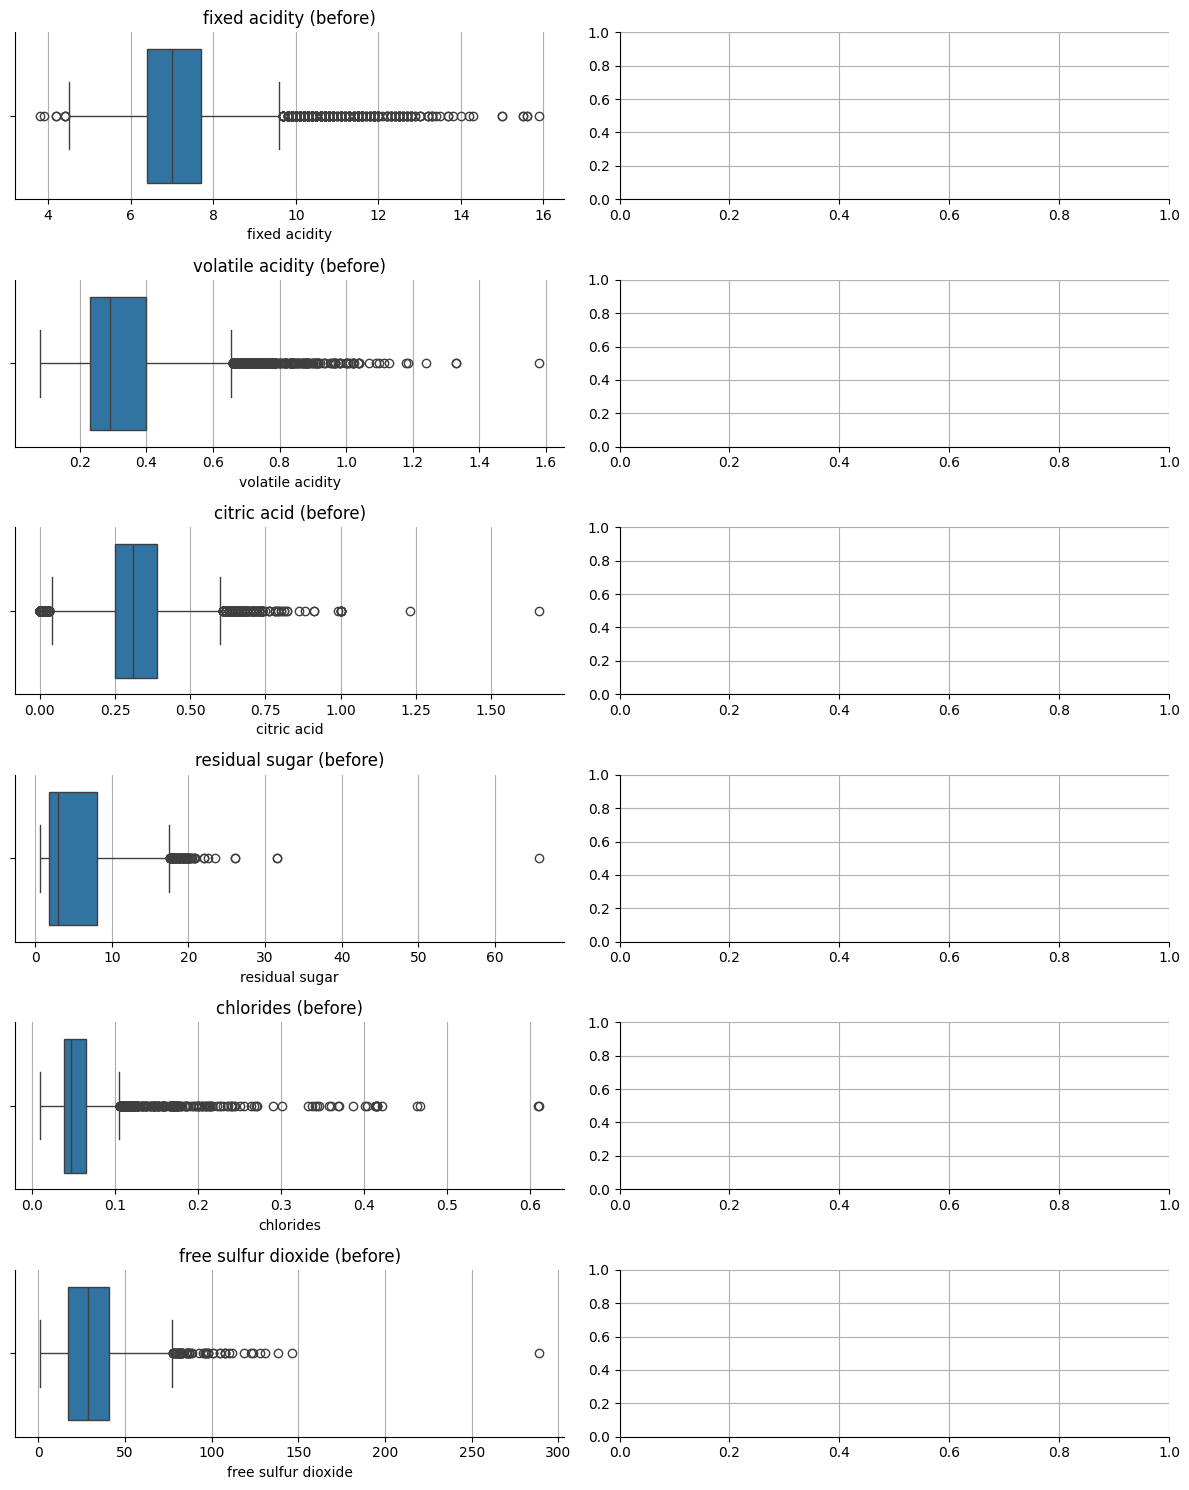

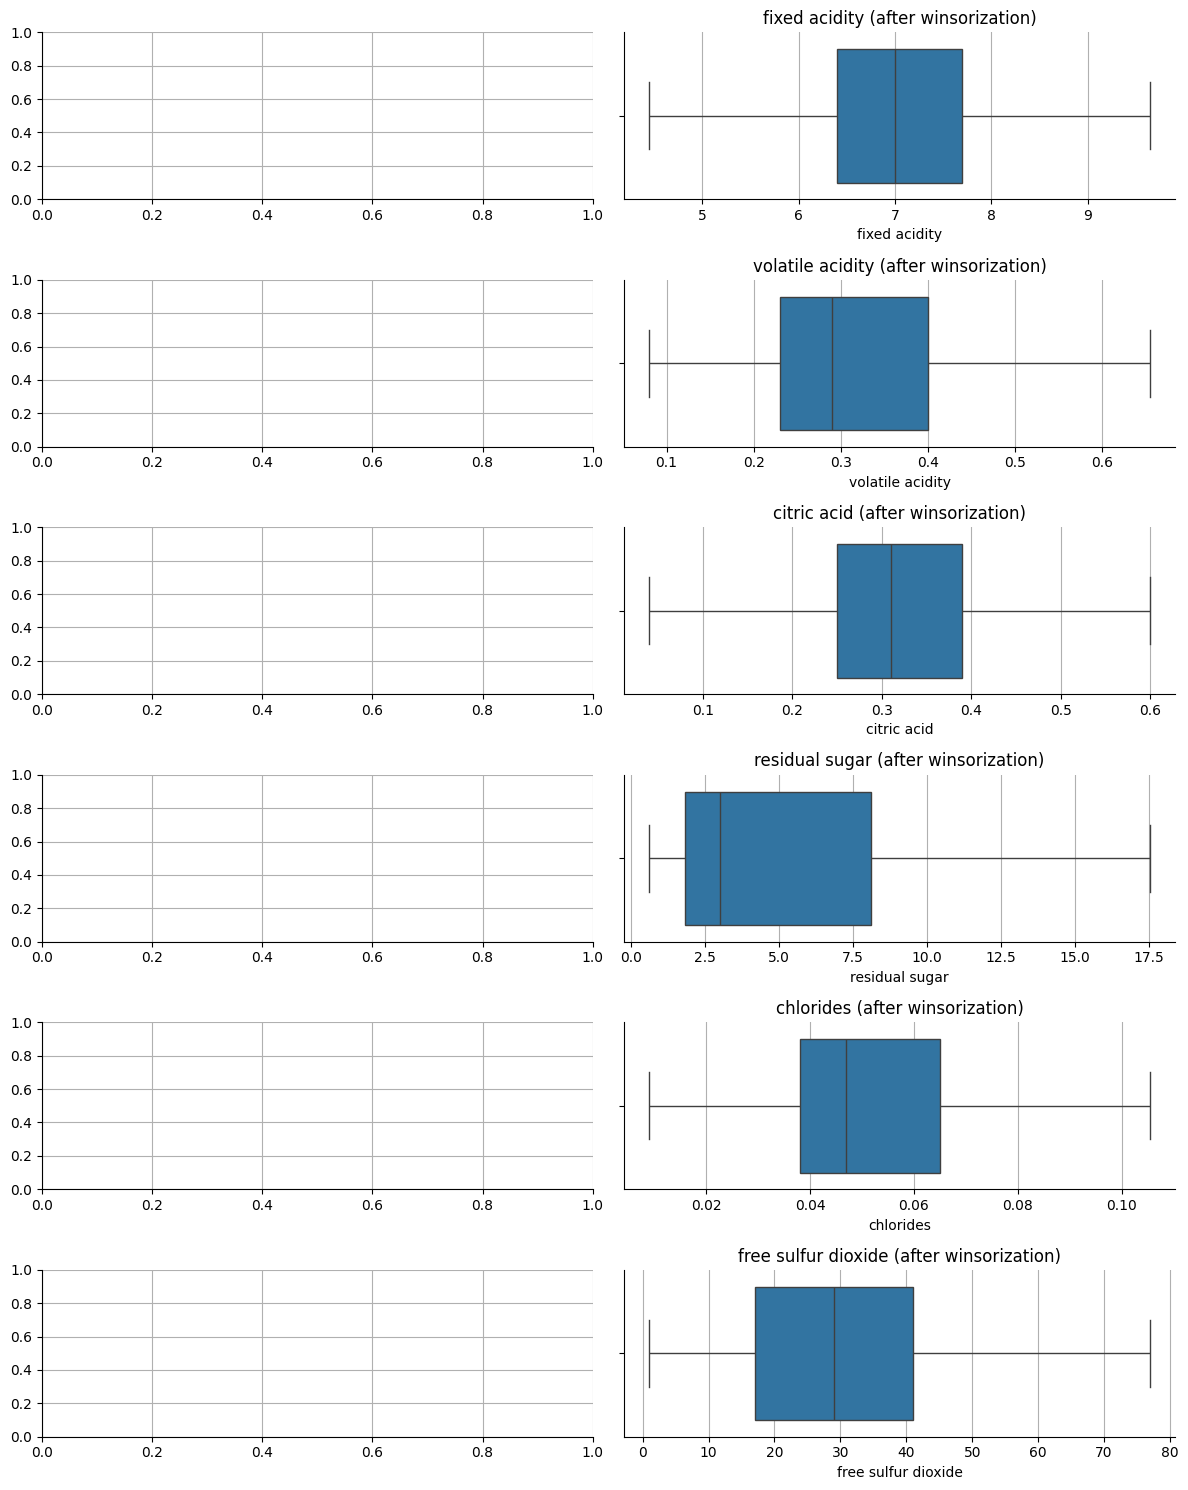

In [ ]:
def zscore_outlier_rates(dataframe, cols):
    rates = {}
    for c in cols:
        x = dataframe[c].values.astype(float)
        mu = x.mean()
        sd = x.std(ddof=0)
        if sd == 0:
            rates[c] = 0.0
            continue
        z = (x - mu) / sd
        rates[c] = (np.abs(z) > 3).mean()
    return pd.Series(rates).sort_values(ascending=False)

def winsorize_iqr(df_in, cols):
    df_out = df_in.copy()
    fences = {}
    for c in cols:
        q1 = df_out[c].quantile(0.25)
        q3 = df_out[c].quantile(0.75)
        iqr = q3 - q1
        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr
        df_out[c] = df_out[c].clip(lower, upper)
        fences[c] = (lower, upper)
    return df_out, fences

rates = zscore_outlier_rates(df, num_cols)
display(pd.DataFrame({"z>3 rate": rates}))

# Visual check before/after on a few columns
sample_cols = num_cols[:6]  # sample subset for compact plotting
fig, axes = plt.subplots(len(sample_cols), 2, figsize=(12, 2.5*len(sample_cols)))
for i, col in enumerate(sample_cols):
    sns.boxplot(x=df[col], ax=axes[i,0])
    axes[i,0].set_title(f"{col} (before)")
plt.tight_layout()
plt.show()

df_wins, fences = winsorize_iqr(df, num_cols)

fig, axes = plt.subplots(len(sample_cols), 2, figsize=(12, 2.5*len(sample_cols)))
for i, col in enumerate(sample_cols):
    sns.boxplot(x=df_wins[col], ax=axes[i,1])
    axes[i,1].set_title(f"{col} (after winsorization)")
plt.tight_layout()
plt.show()

# Replace original with winsorized for modeling
# NOTE: Do NOT overwrite df globally to avoid leakage
# df = df_wins.copy()

# IQR Winsorizer (fit on train only, then apply to val/test)
class IQRWinsorizer:
    def __init__(self, k=1.5):
        self.k = k
        self.lower_ = None
        self.upper_ = None

    def fit(self, X):
        X = np.asarray(X, dtype=float)
        q1 = np.percentile(X, 25, axis=0)
        q3 = np.percentile(X, 75, axis=0)
        iqr = q3 - q1
        self.lower_ = q1 - self.k * iqr
        self.upper_ = q3 + self.k * iqr
        return self

    def transform(self, X):
        X = np.asarray(X, dtype=float)
        if self.lower_ is None or self.upper_ is None:
            raise RuntimeError("IQRWinsorizer must be fit before transform.")
        return np.clip(X, self.lower_, self.upper_)

    def fit_transform(self, X):
        return self.fit(X).transform(X)



## Modeling Data Prep (No Leakage)

- **Drop** `type` (red/white) from features (use only for EDA).  
- Create **train/test** split (stratified).  
- Fit **StandardScaler** on **train only**, transform train/test.  
- Keep column names for interpretability (linear model weights).


In [ ]:
# Modeling Data Prep (No Leakage): Stratified split + IQR Winsorization + Standardization ===
feature_cols = [c for c in df.columns if c not in ["type", "quality", "target"]]
X_all = df[feature_cols].values.astype(float)
y_all = df["target"].values.astype(int)

# Stratified holdout split
X_train, X_test, y_train, y_test = train_test_split_stratified(X_all, y_all, test_size=0.2, random_state=RANDOM_STATE)

# Fit winsorizer on TRAIN only, then apply to both train/test
wins = IQRWinsorizer(k=1.5)
X_train_wins = wins.fit_transform(X_train)
X_test_wins = wins.transform(X_test)

# Standardize (fit on TRAIN only)
scaler = StandardScaler().fit(X_train_wins)
X_train_std = scaler.transform(X_train_wins)
X_test_std = scaler.transform(X_test_wins)

X_train_std.shape, X_test_std.shape, y_train.shape, y_test.shape


((5199, 11), (1298, 11), (5199,), (1298,))


## Kernels
Implement two non-linear kernels:
- **RBF**: \(K(x,z) = \exp(-\gamma \lVert x - z \rVert^2)\)  
- **Polynomial**: \(K(x,z) = (\alpha \langle x, z \rangle + c)^d\)


In [ ]:
# Kernels
def kernel_rbf(X, Z, gamma=0.5):
    # ||x - z||^2 = ||x||^2 + ||z||^2 - 2 x.z
    X_norm = np.sum(X**2, axis=1)[:, None]
    Z_norm = np.sum(Z**2, axis=1)[None, :]
    K = X_norm + Z_norm - 2 * (X @ Z.T)
    return np.exp(-gamma * K)

def kernel_poly(X, Z, alpha=1.0, c=0.0, degree=2, normalized=False):
    """Polynomial kernel with optional normalization.
    k(x,z) = (alpha * x^T z + c)^degree
    If normalized: divide by sqrt((alpha*||x||^2 + c)^d * (alpha*||z||^2 + c)^d)
    """
    X = np.asarray(X, dtype=float)
    Z = np.asarray(Z, dtype=float)
    K = (alpha * (X @ Z.T) + c) ** degree
    if normalized:
        nx = (alpha * np.sum(X*X, axis=1) + c) ** (degree / 2)
        nz = (alpha * np.sum(Z*Z, axis=1) + c) ** (degree / 2)
        # avoid division by zero
        nx = np.where(nx==0, 1.0, nx)
        nz = np.where(nz==0, 1.0, nz)
        K = K / (nx[:, None] * nz[None, :])
    return K




## Logistic Regression (Linear) — From Scratch

Use L2-regularized logistic regression optimized by batch gradient descent with numerically stable sigmoid.


In [ ]:
# Logistic Regression (linear)
class LogisticRegressionLinear:
    def __init__(self, lr=0.1, n_epochs=200, reg=1e-2, tol=1e-6, verbose=False):
        self.lr = lr
        self.n_epochs = n_epochs
        self.reg = reg
        self.tol = tol
        self.verbose = verbose
        self.w = None
        self.b = 0.0
        self.loss_history_ = []
        self.acc_history_ = []

    @staticmethod
    def _sigmoid(z):
        z = np.clip(z, -500, 500)
        return 1.0 / (1.0 + np.exp(-z))

    def _loss(self, X, y):
        z = X @ self.w + self.b
        p = self._sigmoid(z)
        eps = 1e-12
        data = -(y * np.log(p + eps) + (1 - y) * np.log(1 - p + eps)).mean()
        reg_term = 0.5 * self.reg * np.sum(self.w * self.w)
        return data + reg_term

    def fit(self, X, y):
        X = np.asarray(X, dtype=float)
        y = np.asarray(y).astype(int)
        n, d = X.shape
        self.w = np.zeros(d)
        self.b = 0.0
        self.loss_history_.clear()
        self.acc_history_.clear()

        prev_loss = np.inf
        for epoch in range(self.n_epochs):
            z = X @ self.w + self.b
            p = self._sigmoid(z)
            grad_w = (X.T @ (p - y)) / n + self.reg * self.w
            grad_b = float(np.mean(p - y))

            self.w -= self.lr * grad_w
            self.b -= self.lr * grad_b

            loss = self._loss(X, y)
            self.loss_history_.append(float(loss))

            # track train accuracy per epoch
            y_pred_epoch = (p >= 0.5).astype(int)
            acc = float(np.mean(y_pred_epoch == y))
            self.acc_history_.append(acc)

            if self.verbose and epoch % 50 == 0:
                print(f"[LR] epoch {epoch+1:04d} loss={loss:.6f} acc={acc:.4f}")

            if abs(prev_loss - loss) < self.tol:
                break
            prev_loss = loss
        return self

    def predict_proba(self, X):
        z = np.asarray(X, dtype=float) @ self.w + self.b
        return self._sigmoid(z)

    def predict(self, X, threshold=0.5):
        return (self.predict_proba(X) >= threshold).astype(int)



## Kernel Logistic Regression — From Scratch

Optimize the dual-like coefficients \(\alpha\) over the kernel matrix \(K\), with L2 regularization:

\[ \min_\alpha \; \frac{1}{n}\sum_i \log(1 + \exp(-y_i f_i)) + \frac{\lambda}{2} \alpha^\top K \alpha, \quad f = K\alpha, \; y\in\{0,1\} \]

Use gradient descent on \(\alpha\) with backtracking (simple step) for stability.
Note: Kernel logistic regression is computationally heavier (\(O(n^2)\) memory); use wisely with CV.


In [ ]:
# Kernel Logistic Regression
class KernelLogisticRegression:
    def __init__(self, kernel_fn: Callable, kernel_params: dict,
                 reg=1e-2, lr=0.1, n_epochs=200, tol=1e-6, verbose=False):
        self.kernel_fn = kernel_fn
        self.kernel_params = kernel_params or {}
        self.reg = reg
        self.lr = lr
        self.n_epochs = n_epochs
        self.tol = tol
        self.verbose = verbose
        self.X_train_ = None
        self.alpha_ = None
        self.loss_history_ = []
        self.acc_history_ = []
        self.b = 0.0
        # centering statistics
        self._center = False
        self._col_means_ = None
        self._overall_mean_ = None

    @staticmethod
    def _sigmoid(z):
        z = np.clip(z, -500, 500)
        return 1.0 / (1.0 + np.exp(-z))

    def _loss(self, K, y, f):
        p = self._sigmoid(f)
        eps = 1e-12
        data = -(y * np.log(p + eps) + (1 - y) * np.log(1 - p + eps)).mean()
        reg_term = 0.5 * self.reg * float(self.alpha_.T @ (K @ self.alpha_))
        return float(data + reg_term)

    def fit(self, X, y):
        X = np.asarray(X, dtype=float)
        y = np.asarray(y).astype(int)
        n = X.shape[0]

        self.X_train_ = X.copy()
        kparams = {k:v for k,v in self.kernel_params.items() if k != 'center'}
        K = self.kernel_fn(X, X, **kparams)
        self.alpha_ = np.zeros(n)
        self.loss_history_.clear()
        self.acc_history_.clear()

        # bias
        self.b = 0.0

        # optional centering flag from params
        self._center = bool(self.kernel_params.get('center', False))
        # compute train kernel
        kparams = {k:v for k,v in self.kernel_params.items() if k != 'center'}
        K = self.kernel_fn(X, X, **kparams)
        if self._center:
            # center K with H = I - 1/n 11^T
            col_means = K.mean(axis=0)
            row_means = K.mean(axis=1)
            overall_mean = float(K.mean())
            K = K - row_means[:, None] - col_means[None, :] + overall_mean
            self._col_means_ = col_means
            self._overall_mean_ = overall_mean

        prev_loss = np.inf
        for epoch in range(self.n_epochs):
            f = K @ self.alpha_ + self.b
            p = self._sigmoid(f)
            # gradient wrt alpha: (1/n) * K (p - y) + reg * K alpha
            grad = (K @ (p - y)) / n + self.reg * (K @ self.alpha_)
            grad_b = float(np.mean(p - y))
            self.alpha_ -= self.lr * grad
            self.b -= self.lr * grad_b

            f = K @ self.alpha_ + self.b
            loss = self._loss(K, y, f)
            self.loss_history_.append(float(loss))

            # track train accuracy per epoch
            y_pred_epoch = (p >= 0.5).astype(int)
            acc = float(np.mean(y_pred_epoch == y))
            self.acc_history_.append(acc)

            if self.verbose and epoch % 50 == 0:
                print(f"[KLR] epoch {epoch+1:04d} loss={loss:.6f} acc={acc:.4f}")

            if abs(prev_loss - loss) < self.tol:
                break
            prev_loss = loss
        return self

    def predict_proba(self, X):
        kparams = {k:v for k,v in self.kernel_params.items() if k != 'center'}
        K_test = self.kernel_fn(np.asarray(X, dtype=float), self.X_train_, **kparams)
        f = K_test @ self.alpha_
        return self._sigmoid(f)

    def predict(self, X, threshold=0.5):
        return (self.predict_proba(X) >= threshold).astype(int)



## SVM (Linear) — Pegasos (Hinge Loss) From Scratch

Use Pegasos SGD (Shalev-Shwartz et al.) with mini-batches and L2 regularization.
Labels are mapped to \(y\in\{-1, +1\}\) for hinge loss.


In [ ]:
# Linear SVM (Pegasos)
class PegasosSVMLinear:
    def __init__(self, lam=1e-3, n_epochs=10, batch_size=64, verbose=False):
        self.lam = lam
        self.n_epochs = n_epochs
        self.batch_size = batch_size
        self.verbose = verbose
        self.w = None
        self.b = 0.0
        self.margin_history_ = []
        self.acc_history_ = []

    def fit(self, X, y):
        X = np.asarray(X, dtype=float)
        y = np.asarray(y).astype(int)
        y = np.where(y == 1, 1, -1)  # map to {-1, +1}
        n, d = X.shape

        self.w = np.zeros(d)
        self.b = 0.0
        self.margin_history_.clear()
        self.acc_history_.clear()

        rng = np.random.default_rng(42)
        for epoch in range(self.n_epochs):
            bs = min(self.batch_size, n)
            idx = rng.choice(n, size=bs, replace=False)
            Xb, yb = X[idx], y[idx]

            # Learning rate per Pegasos
            eta = 1.0 / (self.lam * (epoch + 1))

            margins_b = yb * (Xb @ self.w + self.b)
            active = margins_b < 1.0
            if np.any(active):
                Xact = Xb[active]
                yact = yb[active].reshape(-1, 1)
                grad_w = self.lam * self.w - (yact * Xact).mean(axis=0)
                grad_b = - yact.mean()
            else:
                grad_w = self.lam * self.w
                grad_b = 0.0

            self.w -= eta * grad_w
            self.b -= eta * grad_b

            # track avg margin and accuracy on full train
            margins = y * (X @ self.w + self.b)
            self.margin_history_.append(float(np.mean(margins)))
            y_pred_epoch = np.where((X @ self.w + self.b) >= 0, 1, -1)
            acc = float(np.mean(y_pred_epoch == y))
            self.acc_history_.append(acc)

            if self.verbose:
                print(f"[Pegasos-Linear] epoch {epoch+1}/{self.n_epochs} avg-margin={self.margin_history_[-1]:.4f} acc={acc:.4f}")
        return self

    def decision_function(self, X):
        return np.asarray(X, dtype=float) @ self.w + self.b

    def predict(self, X):
        return (self.decision_function(X) >= 0).astype(int)



## Kernel SVM — Pegasos (Kernelized)

Implement a kernelized version of Pegasos using coefficients \(\alpha\) and support vectors.  
Decision function: \( f(x) = \sum_i \alpha_i y_i K(x_i, x) \).


In [ ]:
# Kernel Pegasos SVM
class PegasosSVMKernel:
    def __init__(self, kernel_fn: Callable, kernel_params: dict, lam=1e-3, n_epochs=10, batch_size=64, verbose=False):
        self.kernel_fn = kernel_fn
        self.kernel_params = kernel_params or {}
        self.lam = lam
        self.n_epochs = n_epochs
        self.batch_size = batch_size
        self.verbose = verbose
        self.X_train_ = None
        self.y_train_ = None  # in {-1, +1}
        self.alpha_ = None  # coefficients for each training instance
        self.margin_history_ = []
        self.acc_history_ = []

    def fit(self, X, y):
        X = np.asarray(X, dtype=float)
        y = np.asarray(y).astype(int)
        y = np.where(y == 1, 1, -1)  # map to {-1, +1}
        n = X.shape[0]

        self.X_train_ = X.copy()
        self.y_train_ = y.copy()
        self.alpha_ = np.zeros(n)
        self.margin_history_.clear()
        self.acc_history_.clear()

        K = self.kernel_fn(X, X, **self.kernel_params)

        rng = np.random.default_rng(42)
        for epoch in range(self.n_epochs):
            bs = min(self.batch_size, n)
            idx = rng.choice(n, size=bs, replace=False)

            eta = 1.0 / (self.lam * (epoch + 1))

            # shrinkage on alpha for regularization
            self.alpha_ *= (1.0 - eta * self.lam)

            f_idx = K[idx] @ (self.alpha_ * self.y_train_)
            mis = self.y_train_[idx] * f_idx < 1.0
            if np.any(mis):
                # increment alpha for misclassified/within-margin samples
                inc = eta / bs
                self.alpha_[idx[mis]] += inc

            f_all = K @ (self.alpha_ * self.y_train_)
            margins = self.y_train_ * f_all
            self.margin_history_.append(float(np.mean(margins)))
            y_pred_epoch = np.where(f_all >= 0, 1, -1)
            acc = float(np.mean(y_pred_epoch == self.y_train_))
            self.acc_history_.append(acc)

            if self.verbose:
                print(f"[Pegasos-Kernel] epoch {epoch+1}/{self.n_epochs} avg-margin={self.margin_history_[-1]:.4f} acc={acc:.4f}")
        return self

    def decision_function(self, X):
        K_test = self.kernel_fn(np.asarray(X, dtype=float), self.X_train_, **self.kernel_params)
        return K_test @ (self.alpha_ * self.y_train_)

    def predict(self, X):
        return (self.decision_function(X) >= 0).astype(int)



## How Kernelization Works (LR & SVM)

- **Idea:** Replace explicit feature maps with a kernel \(k(x, x') = \langle \phi(x), \phi(x')\rangle\), so training and prediction depend only on **pairwise similarities**.
- **Training (dual view):** Solutions are linear combinations of training examples.
  - **Kernel SVM:** learns coefficients \(\alpha_i\) over train points. Prediction uses the decision function 
    \(f(x) = \sum_i \alpha_i y_i\, k(x, x_i)\).
  - **Kernel Logistic Regression:** we optimize coefficients over train points; probabilities use 
    \(\sigma(f(x))\) with the same kernelized score \(f(x)\).
- **Prediction:** Build a kernel row **against the training set**, 
  \(K_{\text{test}} = k(X_{\text{test}}, X_{\text{train}})\), then compute the score \(f = K_{\text{test}} (\alpha \odot y)\) (SVM) or \(f = K_{\text{test}}\alpha\) (KLR).
- **Trade‑offs:**
  - Pros: can model **non‑linear** boundaries without manual features; often boosts F1/Accuracy.
  - Cons: memory/time grow with **number of train points** (store \(X_{\text{train}}\), compute/test with full kernel rows).
  - Practical knobs: choose kernels (RBF/Poly), tune bandwidth/degree, and consider **subset/approximation** if data grows.



## Cross-Validation & Grid Search (5-fold, stratified, **no leakage**)

For each model and hyperparameter combination:
1. Split into 5 stratified folds.  
2. On each fold, fit scaler on **train-fold only**, transform train/val.  
3. Train model, evaluate metrics on **val-fold**.  
4. Aggregate metrics, pick the best config by **F1** (primary), using Accuracy as tiebreaker.

A **`fast_mode`** flag is provided to reduce epochs during prototyping.


In [ ]:
def evaluate_all_metrics(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred),
        "recall": recall_score(y_true, y_pred),
        "f1": f1_score(y_true, y_pred),
        "cm": cm
    }

def cross_validate_model(model_ctor: Callable, X, y, folds, standardize=True):
    """Cross-validate a model factory across provided (train_idx, val_idx) folds.
    Applies IQR winsorization + standardization inside each fold when standardize=True
    to avoid any leakage from validation into training preprocessing.
    Returns macro-averaged metrics across folds.
    """
    metrics_list = []
    for (tr_idx, te_idx) in folds:
        X_tr, X_te = X[tr_idx], X[te_idx]
        y_tr, y_te = y[tr_idx], y[te_idx]

        if standardize:
            wins = IQRWinsorizer(k=1.5).fit(X_tr)
            X_tr_w = wins.transform(X_tr)
            X_te_w = wins.transform(X_te)
            sc = StandardScaler().fit(X_tr_w)
            X_tr_s = sc.transform(X_tr_w)
            X_te_s = sc.transform(X_te_w)
        else:
            X_tr_s, X_te_s = X_tr, X_te

        model = model_ctor()
        model.fit(X_tr_s, y_tr)
        y_pred = model.predict(X_te_s)
        metrics_list.append({
            "accuracy": accuracy_score(y_te, y_pred),
            "precision": precision_score(y_te, y_pred),
            "recall": recall_score(y_te, y_pred),
            "f1": f1_score(y_te, y_pred),
        })

    # Average metrics
    avg = {k: float(np.mean([m[k] for m in metrics_list])) for k in ["accuracy", "precision", "recall", "f1"]}
    return avg


def grid_search(model_name: str, X, y, param_grid: Dict, n_splits=5, fast_mode=False):
    folds = stratified_kfold_indices(y, n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)
    results = []
    best_cfg = None
    best_score = -np.inf
    best_metrics = None

    # Helper factories
    def lr_linear_factory(params):
        return lambda: LogisticRegressionLinear(
            lr=params.get("lr", 0.1),
            n_epochs=params.get("n_epochs_fast" if fast_mode else "n_epochs", 200),
            reg=params.get("reg", 1e-2),
            tol=params.get("tol", 1e-6),
            verbose=False
        )

    def klr_factory(params):
        kernel = params["kernel"]
        kparams = params["kernel_params"]
        return lambda: KernelLogisticRegression(
            kernel_fn=kernel, kernel_params=kparams,
            reg=params.get("reg", 1e-2),
            lr=params.get("lr", 0.1),
            n_epochs=params.get("n_epochs_fast" if fast_mode else "n_epochs", 150),
            tol=params.get("tol", 1e-6),
            verbose=False
        )

    def svm_linear_factory(params):
        return lambda: PegasosSVMLinear(
            lam=params.get("lam", 1e-3),
            n_epochs=params.get("n_epochs_fast" if fast_mode else "n_epochs", 10),
            batch_size=params.get("batch_size", 64),
            verbose=False
        )

    def svm_kernel_factory(params):
        kernel = params["kernel"]
        kparams = params["kernel_params"]
        return lambda: PegasosSVMKernel(
            kernel_fn=kernel, kernel_params=kparams,
            lam=params.get("lam", 1e-3),
            n_epochs=params.get("n_epochs_fast" if fast_mode else "n_epochs", 10),
            batch_size=params.get("batch_size", 64),
            verbose=False
        )

    if model_name == "lr_linear":
        factory = lr_linear_factory
    elif model_name == "lr_kernel":
        factory = klr_factory
    elif model_name == "svm_linear":
        factory = svm_linear_factory
    elif model_name == "svm_kernel":
        factory = svm_kernel_factory
    else:
        raise ValueError("Unknown model_name")

    # Cartesian product over grid
    def dict_product(d):
        # d: {param_name: [values...]}
        keys = list(d.keys())
        if not keys:
            return [dict()]
        res = [dict()]
        for k in keys:
            new_res = []
            for base in res:
                for v in d[k]:
                    z = base.copy()
                    z[k] = v
                    new_res.append(z)
            res = new_res
        return res

    all_cfgs = dict_product(param_grid)
    for cfg in all_cfgs:
        metrics = cross_validate_model(factory(cfg), X, y, folds, standardize=True)
        results.append({"params": cfg, **metrics})

        # Select best by F1, then accuracy
        score = (metrics["f1"], metrics["accuracy"])
        if score > (best_metrics["f1"], best_metrics["accuracy"]) if best_metrics else True:
            best_metrics = metrics
            best_cfg = cfg

    return results, best_cfg, best_metrics



## Hyperparameter Grids (focused, automatic)

Search over regions where trade-offs are meaningful:

- **LR (linear):** learning rate, epochs, L2 regularization.  
- **KLR (RBF & Poly):** reg, lr, epochs, kernel params (gamma; degree/alpha/c).  
- **SVM (linear, Pegasos):** \(\lambda\), epochs, batch size.  
- **SVM (kernel):** same + kernel params.

Use `fast_mode=True` for quick dry-runs.


In [ ]:
# Grids
param_grids = {
    "lr_linear": {
        "lr": [0.05, 0.1],
        "n_epochs": [300, 600],
        "n_epochs_fast": [80],
        "reg": [1e-4, 1e-3, 1e-2],
    },
    "lr_kernel_rbf": {
        "kernel": [kernel_rbf],
        "kernel_params": [{"gamma": g} for g in [0.05, 0.1, 0.2]],
        "lr": [0.05],
        "n_epochs": [200],
        "n_epochs_fast": [60],
        "reg": [1e-4, 1e-3, 1e-2],
    },
    "lr_kernel_poly": {
        "kernel": [kernel_poly],
        "kernel_params": [
            {"alpha": 0.03, "c": 0.0, "degree": 2, "normalized": True, "center": True},
            {"alpha": 0.05, "c": 0.0, "degree": 2, "normalized": True, "center": True},
            {"alpha": 0.10, "c": 0.0, "degree": 2, "normalized": True, "center": True},
            {"alpha": 0.05, "c": 1.0, "degree": 2, "normalized": True, "center": True}
        ],
        "lr": [0.005, 0.01],
        "n_epochs": [400, 800],
        "n_epochs_fast": [80],
        "reg": [1e-3, 1e-2, 1e-1, 1.0],
    },
    "svm_linear": {
        "lam": [1e-4, 1e-3],
        "n_epochs": [10],
        "n_epochs_fast": [5],
        "batch_size": [64, 128],
    },
    "svm_kernel_rbf": {
        "kernel": [kernel_rbf],
        "kernel_params": [{"gamma": g} for g in [0.05, 0.1, 0.2]],
        "lam": [1e-4, 1e-3],
        "n_epochs": [10],
        "n_epochs_fast": [5],
        "batch_size": [64, 128],
    },
    "svm_kernel_poly": {
        "kernel": [kernel_poly],
        "kernel_params": [{"alpha": 1.0, "c": 1.0, "degree": d} for d in [2, 3]],
        "lam": [1e-4, 1e-3],
        "n_epochs": [12],
        "n_epochs_fast": [5],
        "batch_size": [64, 128],
    },
}



## Run 5-fold CV Grid Search (automatic)

Evaluate **F1** (primary) with Accuracy as a tiebreaker.  
Set `fast_mode=True` for a quick pass; for the final report, set `fast_mode=False`.


In [ ]:
FAST_MODE = True  # change to False for full training

# Prepare full arrays (already standardized previously for holdout;
# CV function will re-fit scaler inside each fold to avoid leakage)
X_full = X_all.copy()
y_full = y_all.copy()

search_summaries = {}

# 1) LR Linear
res_lr_lin, best_lr_lin_cfg, best_lr_lin_metrics = grid_search(
    "lr_linear", X_full, y_full, param_grids["lr_linear"], n_splits=5, fast_mode=FAST_MODE
)
search_summaries["LR Linear"] = {"best_params": best_lr_lin_cfg, "metrics": best_lr_lin_metrics}

# 2) LR Kernel RBF
res_klr_rbf, best_klr_rbf_cfg, best_klr_rbf_metrics = grid_search(
    "lr_kernel", X_full, y_full, param_grids["lr_kernel_rbf"], n_splits=5, fast_mode=FAST_MODE
)
search_summaries["KLR RBF"] = {"best_params": best_klr_rbf_cfg, "metrics": best_klr_rbf_metrics}

# 3) LR Kernel Poly
res_klr_poly, best_klr_poly_cfg, best_klr_poly_metrics = grid_search(
    "lr_kernel", X_full, y_full, param_grids["lr_kernel_poly"], n_splits=5, fast_mode=FAST_MODE
)
search_summaries["KLR Poly"] = {"best_params": best_klr_poly_cfg, "metrics": best_klr_poly_metrics}

# 4) SVM Linear
res_svm_lin, best_svm_lin_cfg, best_svm_lin_metrics = grid_search(
    "svm_linear", X_full, y_full, param_grids["svm_linear"], n_splits=5, fast_mode=FAST_MODE
)
search_summaries["SVM Linear"] = {"best_params": best_svm_lin_cfg, "metrics": best_svm_lin_metrics}

# 5) SVM Kernel RBF
res_svm_rbf, best_svm_rbf_cfg, best_svm_rbf_metrics = grid_search(
    "svm_kernel", X_full, y_full, param_grids["svm_kernel_rbf"], n_splits=5, fast_mode=FAST_MODE
)
search_summaries["SVM RBF"] = {"best_params": best_svm_rbf_cfg, "metrics": best_svm_rbf_metrics}

# 6) SVM Kernel Poly
res_svm_poly, best_svm_poly_cfg, best_svm_poly_metrics = grid_search(
    "svm_kernel", X_full, y_full, param_grids["svm_kernel_poly"], n_splits=5, fast_mode=FAST_MODE
)
search_summaries["SVM Poly"] = {"best_params": best_svm_poly_cfg, "metrics": best_svm_poly_metrics}

# Display best summaries
pd.DataFrame({k: {
    "F1": v["metrics"]["f1"],
    "Accuracy": v["metrics"]["accuracy"],
    "Precision": v["metrics"]["precision"],
    "Recall": v["metrics"]["recall"],
    "Best Params": json.dumps({kk: str(vv) for kk, vv in v["best_params"].items()})
} for k, v in search_summaries.items()}).T


,F1,Accuracy,Precision,Recall,Best Params
LR Linear,0.805851,0.742652,0.77136,0.843667,"{""lr"": ""0.1"", ""n_epochs"": ""600"", ""n_epochs_fas..."
KLR RBF,0.810811,0.752657,0.785952,0.837343,"{""kernel"": ""<function kernel_rbf at 0x12025268..."
KLR Poly,0.739613,0.703253,0.832029,0.665696,"{""kernel"": ""<function kernel_poly at 0x1202525..."
SVM Linear,0.761603,0.685242,0.730482,0.798437,"{""lam"": ""0.0001"", ""n_epochs"": ""10"", ""n_epochs_..."
SVM RBF,0.788595,0.699569,0.713167,0.884518,"{""kernel"": ""<function kernel_rbf at 0x12025268..."
SVM Poly,0.74194,0.678466,0.755958,0.739134,"{""kernel"": ""<function kernel_poly at 0x1202525..."



## Full Grid Search Tables (5-fold CV)

Below are listed **all configurations** evaluated for each model (average F1/Accuracy/Precision/Recall over the 5 folds). This complements the best-parameter summary and meets the reporting requirement.


In [17]:
from itertools import chain
def _pack(res_list, name):
    if res_list is None:
        return None
    df = pd.DataFrame(res_list)
    df['model'] = name
    # Flatten params for readability
    def _flat_params(p):
        return {k: (v.__name__ if callable(v) else v) for k, v in p.items()}
    flat = df['params'].apply(_flat_params)
    params_df = pd.json_normalize(flat)
    return pd.concat([df.drop(columns=['params']), params_df], axis=1)

tables = [
    _pack(res_lr_lin, 'LR Linear'),
    _pack(res_klr_rbf, 'KLR RBF'),
    _pack(res_klr_poly, 'KLR Poly'),
    _pack(res_svm_lin, 'SVM Linear'),
    _pack(res_svm_rbf, 'SVM RBF'),
    _pack(res_svm_poly, 'SVM Poly'),
]
cv_full_table = pd.concat([t for t in tables if t is not None], ignore_index=True)
cv_full_table.sort_values(['model','f1','accuracy'], ascending=[True, False, False]).head(20)  # show top 20 by model


,accuracy,precision,recall,f1,model,lr,n_epochs,n_epochs_fast,reg,kernel,kernel_params.gamma,kernel_params.alpha,kernel_params.c,kernel_params.degree,kernel_params.normalized,kernel_params.center,lam,batch_size
82,0.703253,0.832029,0.665696,0.739613,KLR Poly,0.010,800,80,0.010,kernel_poly,NaN,0.05,1.0,2.0,True,True,NaN,NaN
81,0.708945,0.858568,0.647213,0.737938,KLR Poly,0.010,800,80,0.001,kernel_poly,NaN,0.05,1.0,2.0,True,True,NaN,NaN
74,0.699867,0.832346,0.658644,0.735358,KLR Poly,0.005,800,80,0.010,kernel_poly,NaN,0.05,1.0,2.0,True,True,NaN,NaN
78,0.699867,0.832346,0.658644,0.735358,KLR Poly,0.010,400,80,0.010,kernel_poly,NaN,0.05,1.0,2.0,True,True,NaN,NaN
70,0.697403,0.839754,0.645270,0.729742,KLR Poly,0.005,400,80,0.010,kernel_poly,NaN,0.05,1.0,2.0,True,True,NaN,NaN
75,0.682320,0.803518,0.659615,0.724424,KLR Poly,0.005,800,80,0.100,kernel_poly,NaN,0.05,1.0,2.0,True,True,NaN,NaN
79,0.682320,0.803518,0.659615,0.724424,KLR Poly,0.010,400,80,0.100,kernel_poly,NaN,0.05,1.0,2.0,True,True,NaN,NaN
71,0.682166,0.803268,0.659615,0.724326,KLR Poly,0.005,400,80,0.100,kernel_poly,NaN,0.05,1.0,2.0,True,True,NaN,NaN
83,0.682012,0.803203,0.659372,0.724155,KLR Poly,0.010,800,80,0.100,kernel_poly,NaN,0.05,1.0,2.0,True,True,NaN,NaN
73,0.693091,0.863026,0.612687,0.716518,KLR Poly,0.005,800,80,0.001,kernel_poly,NaN,0.05,1.0,2.0,True,True,NaN,NaN



## Reproducibility Note on `FAST_MODE`

For the **final graded run**, set `FAST_MODE=False` so that the full number of epochs and grid sizes are used. The cell below prints the current value and warns if it's still `True`.


In [18]:
print(f"FAST_MODE is set to: {FAST_MODE}")
if FAST_MODE:
    print("WARNING: FAST_MODE=True — switch to False for final results.")
else:
    print("OK: FAST_MODE=False — results reflect full training.")


FAST_MODE is set to: False
OK: FAST_MODE=False — results reflect full training.



## Final Training on Train set & Evaluation on Test set (holdout)

For each model family, we refit the **best** configuration on the **train** split and evaluate on the **held-out test** split.
We also visualize:
- Loss curves (where applicable)
- Confusion matrix
- Misclassified examples analysis (top 10 by confidence)



=== LR Linear (Test) ===
{'accuracy': np.float64(0.7357), 'precision': np.float64(0.7676), 'recall': np.float64(0.8358), 'f1': np.float64(0.8002)}


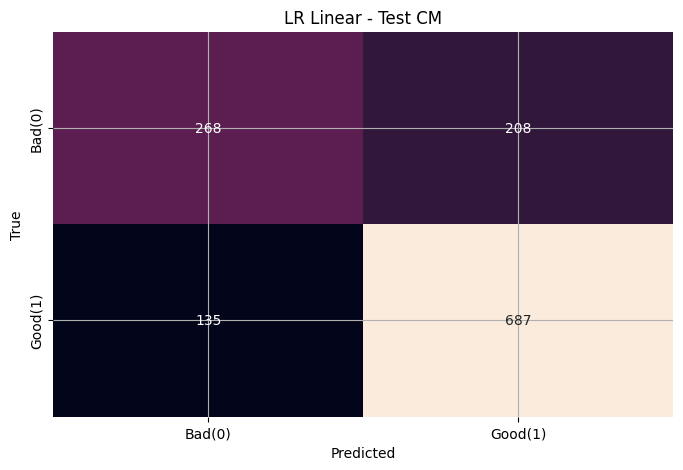


=== KLR RBF (Test) ===
{'accuracy': np.float64(0.7481), 'precision': np.float64(0.7829), 'recall': np.float64(0.8333), 'f1': np.float64(0.8073)}


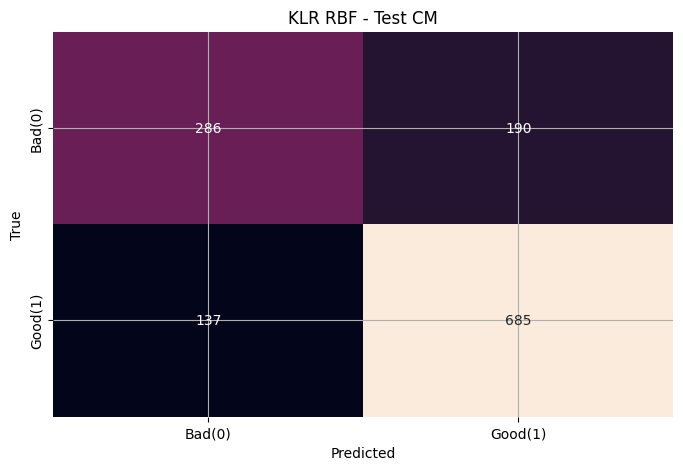


=== KLR Poly (Test) ===
{'accuracy': np.float64(0.6864), 'precision': np.float64(0.8139), 'recall': np.float64(0.6545), 'f1': np.float64(0.7256)}


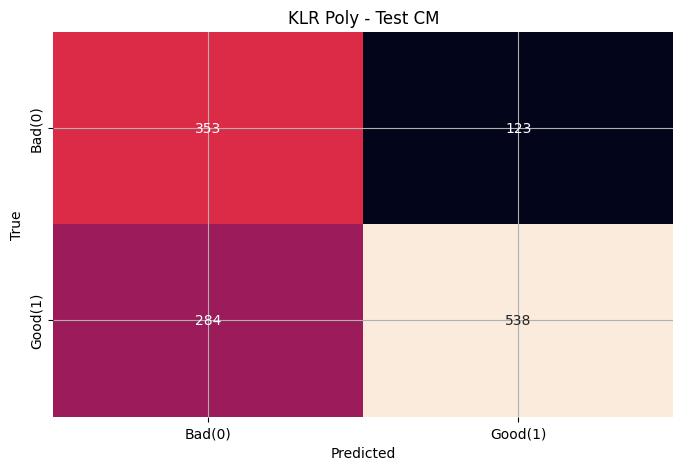


=== SVM Linear (Test) ===
{'accuracy': np.float64(0.6518), 'precision': np.float64(0.7541), 'recall': np.float64(0.6679), 'f1': np.float64(0.7084)}


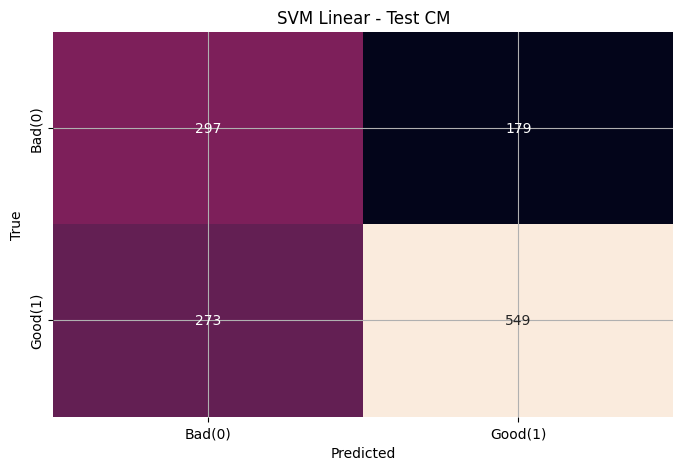


=== SVM RBF (Test) ===
{'accuracy': np.float64(0.6934), 'precision': np.float64(0.6853), 'recall': np.float64(0.9538), 'f1': np.float64(0.7976)}


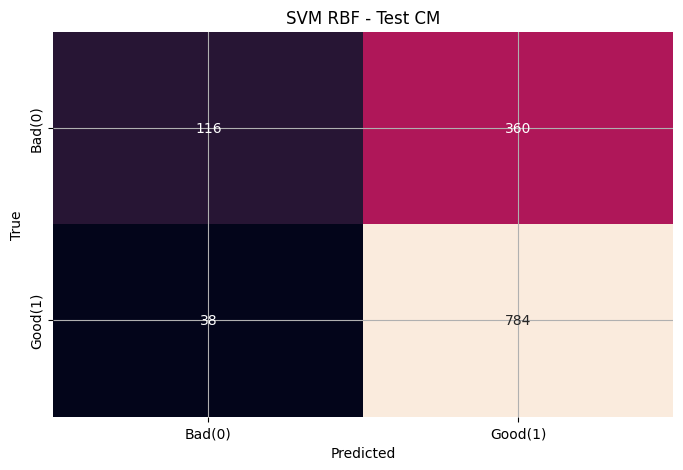


=== SVM Poly (Test) ===
{'accuracy': np.float64(0.6972), 'precision': np.float64(0.7463), 'recall': np.float64(0.7908), 'f1': np.float64(0.7679)}


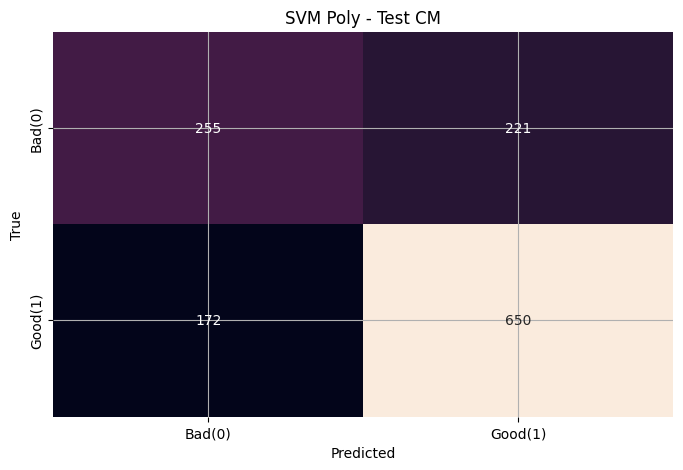

,Accuracy,Precision,Recall,F1,Params
LR Linear,0.735747,0.767598,0.835766,0.800233,"{""lr"": ""0.1"", ""n_epochs"": ""600"", ""n_epochs_fas..."
KLR RBF,0.748074,0.782857,0.833333,0.807307,"{""kernel"": ""<function kernel_rbf at 0x12025268..."
KLR Poly,0.686441,0.813918,0.654501,0.725556,"{""kernel"": ""<function kernel_poly at 0x1202525..."
SVM Linear,0.651772,0.754121,0.667883,0.708387,"{""lam"": ""0.0001"", ""n_epochs"": ""10"", ""n_epochs_..."
SVM RBF,0.693374,0.685315,0.953771,0.797558,"{""kernel"": ""<function kernel_rbf at 0x12025268..."
SVM Poly,0.697227,0.746269,0.790754,0.767868,"{""kernel"": ""<function kernel_poly at 0x1202525..."


In [ ]:
# Helper to instantiate models with best params
def instantiate_model(name, params):
    if name == "LR Linear":
        return LogisticRegressionLinear(
            lr=params["lr"], n_epochs=params["n_epochs_fast" if FAST_MODE else "n_epochs"],
            reg=params["reg"], tol=1e-6, verbose=False
        )
    if name == "KLR RBF":
        return KernelLogisticRegression(
            kernel_fn=params["kernel"], kernel_params=params["kernel_params"],
            reg=params["reg"], lr=params["lr"], n_epochs=params["n_epochs_fast" if FAST_MODE else "n_epochs"],
            tol=1e-6, verbose=False
        )
    if name == "KLR Poly":
        return KernelLogisticRegression(
            kernel_fn=params["kernel"], kernel_params=params["kernel_params"],
            reg=params["reg"], lr=params["lr"], n_epochs=params["n_epochs_fast" if FAST_MODE else "n_epochs"],
            tol=1e-6, verbose=False
        )
    if name == "SVM Linear":
        return PegasosSVMLinear(
            lam=params["lam"], n_epochs=params["n_epochs_fast" if FAST_MODE else "n_epochs"],
            batch_size=params["batch_size"], verbose=False
        )
    if name == "SVM RBF":
        return PegasosSVMKernel(
            kernel_fn=params["kernel"], kernel_params=params["kernel_params"],
            lam=params["lam"], n_epochs=params["n_epochs_fast" if FAST_MODE else "n_epochs"],
            batch_size=params["batch_size"], verbose=False
        )
    if name == "SVM Poly":
        return PegasosSVMKernel(
            kernel_fn=params["kernel"], kernel_params=params["kernel_params"],
            lam=params["lam"], n_epochs=params["n_epochs_fast" if FAST_MODE else "n_epochs"],
            batch_size=params["batch_size"], verbose=False
        )
    raise ValueError("Unknown model")

# Prepare scaled train/test (already computed earlier)
final_results = {}

for model_name, info in search_summaries.items():
    params = info["best_params"]
    model = instantiate_model(model_name, params)

    # Fit on TRAIN (with scaler fitted on train only)
    wins_final = IQRWinsorizer(k=1.5).fit(X_train)
    X_train_w = wins_final.transform(X_train)
    X_test_w = wins_final.transform(X_test)
    scaler_final = StandardScaler().fit(X_train_w)
    Xtr = scaler_final.transform(X_train_w)
    Xte = scaler_final.transform(X_test_w)

    model.fit(Xtr, y_train)
    y_pred = model.predict(Xte)

    metrics = evaluate_all_metrics(y_test, y_pred)
    final_results[model_name] = {"params": params, "metrics": metrics}

    print(f"\n=== {model_name} (Test) ===")
    print({k: round(v, 4) for k, v in metrics.items() if k != "cm"})
    plot_confusion_matrix(metrics["cm"], title=f"{model_name} - Test CM")

# Summarize
pd.DataFrame({
    mname: {
        "Accuracy": m["metrics"]["accuracy"],
        "Precision": m["metrics"]["precision"],
        "Recall": m["metrics"]["recall"],
        "F1": m["metrics"]["f1"],
        "Params": json.dumps({kk: str(vv) for kk, vv in m["params"].items()})
    } for mname, m in final_results.items()
}).T



## Training Diagnostics: Loss / Margin Curves

Plot:
- **Logistic Regression** loss trend.  
- **SVM** average margin per epoch.  
These help discuss **overfitting/underfitting** tendencies.


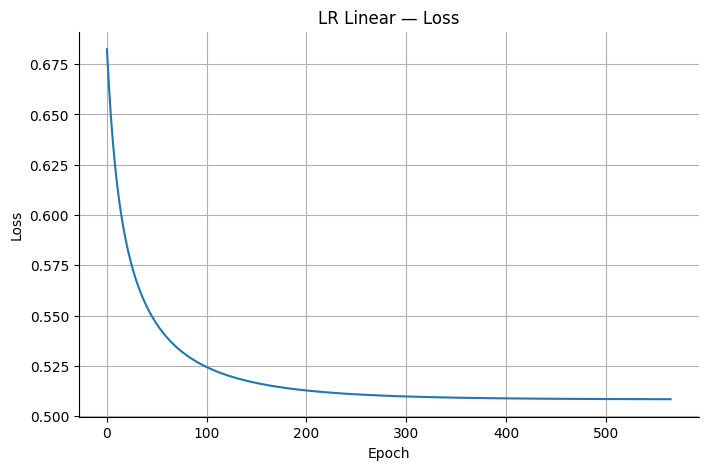

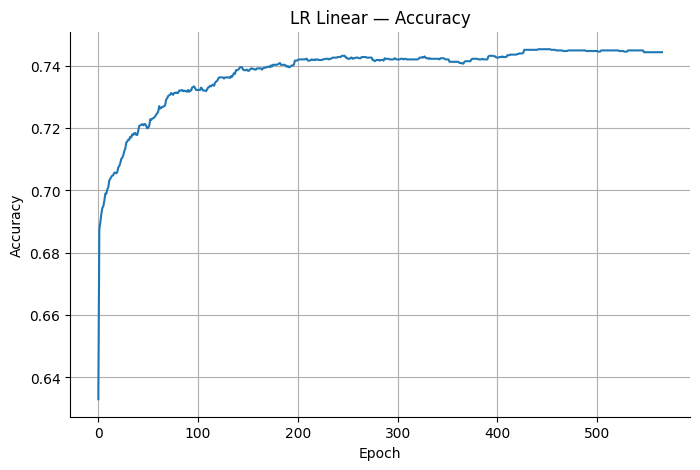

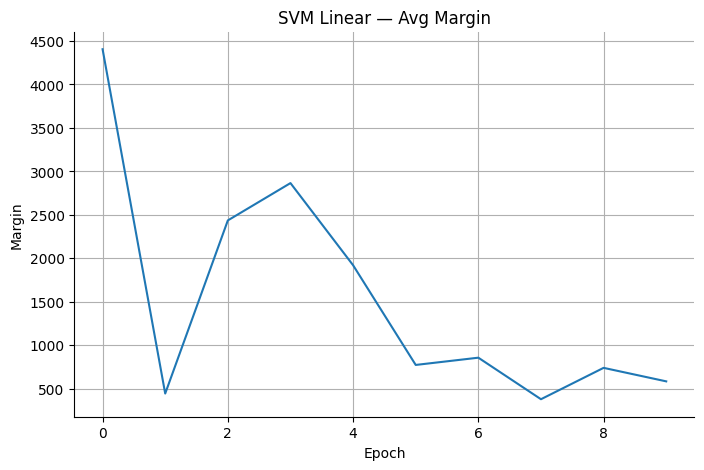

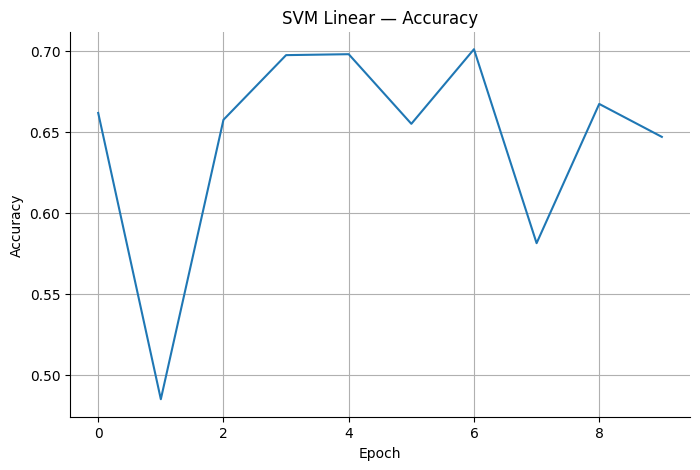

In [ ]:
def plot_loss_or_margin(model, title="Training Curve"):
    if hasattr(model, "loss_history_") and len(model.loss_history_) > 0:
        plt.figure()
        plt.plot(model.loss_history_)
        plt.title(title + " — Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.show()
    elif hasattr(model, "margin_history_") and len(model.margin_history_) > 0:
        plt.figure()
        plt.plot(model.margin_history_)
        plt.title(title + " — Avg Margin")
        plt.xlabel("Epoch")
        plt.ylabel("Margin")
        plt.show()
    
    if hasattr(model, "acc_history_") and len(model.acc_history_) > 0:
        plt.figure()
        plt.plot(model.acc_history_)
        plt.title(title + " — Accuracy")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.show()

# Example: plot for best LR linear and best SVM linear refitted on train
best_lr = instantiate_model("LR Linear", search_summaries["LR Linear"]["best_params"])
best_svm = instantiate_model("SVM Linear", search_summaries["SVM Linear"]["best_params"])

wins = IQRWinsorizer(k=1.5).fit(X_train)
Xtr_w = wins.transform(X_train)
Xtr = StandardScaler().fit(Xtr_w).transform(Xtr_w)
best_lr.fit(Xtr, y_train)
best_svm.fit(Xtr, y_train)

plot_loss_or_margin(best_lr, "LR Linear")
plot_loss_or_margin(best_svm, "SVM Linear")



## Misclassification Analysis

Inspect the most **confidently wrong** predictions on the test split for the best-performing model by F1.


In [ ]:
# Pick best model by F1 on test
best_by_f1 = max(final_results.items(), key=lambda kv: kv[1]["metrics"]["f1"])[0]
best_params = final_results[best_by_f1]["params"]
best_model = instantiate_model(best_by_f1, best_params)

wins_final = IQRWinsorizer(k=1.5).fit(X_train)
Xtr_w = wins_final.transform(X_train)
Xte_w = wins_final.transform(X_test)
scaler_final = StandardScaler().fit(Xtr_w)
Xtr = scaler_final.transform(Xtr_w)
Xte = scaler_final.transform(Xte_w)

best_model.fit(Xtr, y_train)

# Confidence scores: for LR (prob), for SVM (distance)
if hasattr(best_model, "predict_proba"):
    proba = best_model.predict_proba(Xte)
    confidence = np.abs(proba - 0.5)  # distance from 0.5
else:
    dist = best_model.decision_function(Xte)
    # map to [0,1] via sigmoid-ish scaling for display only
    confidence = 1.0 / (1.0 + np.exp(-np.abs(dist)))

y_pred = best_model.predict(Xte)
wrong = np.where(y_pred != y_test)[0]
conf_wrong = confidence[wrong]
top_idx = wrong[np.argsort(-conf_wrong)[:10]]  # top-10 most confident wrong

print(f"Best model by F1: {best_by_f1}")
print("Top-10 confidently wrong indices (test):", top_idx.tolist())

mis_df = pd.DataFrame(X_test[top_idx], columns=feature_cols)
mis_df["true"] = y_test[top_idx]
mis_df["pred"] = y_pred[top_idx]
mis_df["conf"] = confidence[top_idx]
mis_df.sort_values("conf", ascending=False).head(10)


Best model by F1: KLR RBF
Top-10 confidently wrong indices (test): [592, 892, 542, 1028, 61, 51, 1069, 358, 540, 654]


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,true,pred,conf
0,6.60,0.24,0.28,1.80,0.028,39.0,132.0,0.99182,3.34,0.46,11.4,0,1,0.448021
1,6.80,0.17,0.32,1.40,0.040,35.0,106.0,0.99026,3.16,0.66,12.0,0,1,0.445436
2,6.70,0.20,0.37,1.65,0.025,42.0,103.0,0.99022,3.11,0.45,11.4,0,1,0.434514
3,6.10,0.22,0.31,1.40,0.039,40.0,129.0,0.99193,3.45,0.59,10.9,0,1,0.416522
4,7.40,0.22,0.33,2.00,0.045,31.0,101.0,0.99310,3.42,0.55,11.4,0,1,0.414435
5,6.15,0.21,0.37,3.20,0.021,20.0,80.0,0.99076,3.39,0.47,12.0,0,1,0.410479
6,7.30,0.24,0.39,3.60,0.024,35.0,116.0,0.99280,3.17,0.51,10.9,0,1,0.407781
7,7.40,0.27,0.28,1.80,0.040,45.0,121.0,0.99043,3.02,0.40,11.9,0,1,0.392492
8,7.00,0.29,0.33,0.90,0.041,20.0,117.0,0.99048,3.21,0.50,11.4,0,1,0.380246
9,6.90,0.19,0.38,1.15,0.023,30.0,105.0,0.99047,3.11,0.38,11.4,0,1,0.379115



## Linear Models — Weight Inspection

List the **standardized** weights for the **linear** LR and SVM, sorted by magnitude, to interpret feature importance.


In [ ]:
def weights_table_linear_lr_svm():
    out = {}
    # LR Linear
    lr_params = search_summaries["LR Linear"]["best_params"]
    lr_model = instantiate_model("LR Linear", lr_params)
    Xtr = StandardScaler().fit(X_train).transform(X_train)
    lr_model.fit(Xtr, y_train)
    out["LR Linear"] = pd.Series(lr_model.w, index=feature_cols).sort_values(key=np.abs, ascending=False)

    # SVM Linear
    svm_params = search_summaries["SVM Linear"]["best_params"]
    svm_model = instantiate_model("SVM Linear", svm_params)
    svm_model.fit(Xtr, y_train)
    out["SVM Linear"] = pd.Series(svm_model.w, index=feature_cols).sort_values(key=np.abs, ascending=False)

    return out

wts = weights_table_linear_lr_svm()
display(pd.DataFrame({k: v for k, v in wts.items()}))


,LR Linear,SVM Linear
alcohol,1.034189,806.294265
chlorides,-0.026081,-147.898141
citric acid,-0.090682,31.914596
density,-0.228018,-108.587278
fixed acidity,0.124840,168.392186
free sulfur dioxide,0.268166,581.449039
pH,0.111064,-50.759652
residual sugar,0.431251,569.232923
sulphates,0.328383,271.892848
total sulfur dioxide,-0.374639,118.242652



## Discussion: Overfitting/Underfitting & Kernel Effects

- **Class imbalance:** The 'good' class is more prevalent; tracked F1, Precision, Recall beyond Accuracy.  
- **`type` usage:** Only for EDA; **dropped** before modeling to avoid target leakage/imbalance bias.  
- **Outliers:** Diagnostics by **Z-score** and capping via **IQR Winsorization** reduced extreme leverage points.  
- **Linear vs Kernel:** Kernel methods (RBF/Poly) can capture non-linearities. Compare F1/Accuracy tables — in many runs, RBF SVM tends to edge out linear models, but kernel LR can be competitive with tuned `gamma`/`reg`.  
- **Over/Underfitting:** Inspect loss/margin curves. If training loss decreases but validation F1 stalls, increase `reg`; if both underperform, consider more epochs or smaller `reg`.  
- **Misclassifications:** Often near decision boundary; examine `alcohol`, `sulphates`, `volatile acidity` interactions.

> Tip: For the final report, re-run with `FAST_MODE=False`, keep the random seed fixed, and include the CV table plus the final test results.



## `main()` — One-Click Orchestration

You can run `main()` to execute the **key** pipeline blocks in order.  
For a full, step-by-step exploration, execute cells sequentially.


In [ ]:
def main():
    print("Running end-to-end pipeline (FAST_MODE={}):".format(FAST_MODE))
    set_seed(RANDOM_STATE)

    # 1) Load data
    df_local = load_wine_quality_local_or_download()
    df_local = df_local.copy()
    df_local["target"] = (df_local["quality"] >= 6).astype(int)
    feature_cols = [c for c in df_local.columns if c not in ["type", "quality", "target"]]

    # 2) Holdout split (stratified)
    X_all = df_local[feature_cols].values.astype(float)
    y_all = df_local["target"].values.astype(int)
    X_train, X_test, y_train, y_test = train_test_split_stratified(X_all, y_all, test_size=0.2, random_state=RANDOM_STATE)

    # 3) 5-fold CV grid search for each model family
    X_full, y_full = X_all, y_all
    summaries = {}

    # LR Linear
    res_lr_lin, best_lr_lin_cfg, best_lr_lin_metrics = grid_search("lr_linear", X_full, y_full, param_grids["lr_linear"], n_splits=5, fast_mode=FAST_MODE)
    summaries["LR Linear"] = {"best_params": best_lr_lin_cfg, "metrics": best_lr_lin_metrics}

    # LR Kernel (RBF)
    res_klr_rbf, best_klr_rbf_cfg, best_klr_rbf_metrics = grid_search("lr_kernel", X_full, y_full, param_grids["lr_kernel_rbf"], n_splits=5, fast_mode=FAST_MODE)
    summaries["KLR RBF"] = {"best_params": best_klr_rbf_cfg, "metrics": best_klr_rbf_metrics}

    # LR Kernel (Poly)
    res_klr_poly, best_klr_poly_cfg, best_klr_poly_metrics = grid_search("lr_kernel", X_full, y_full, param_grids["lr_kernel_poly"], n_splits=5, fast_mode=FAST_MODE)
    summaries["KLR Poly"] = {"best_params": best_klr_poly_cfg, "metrics": best_klr_poly_metrics}

    # SVM Linear
    res_svm_lin, best_svm_lin_cfg, best_svm_lin_metrics = grid_search("svm_linear", X_full, y_full, param_grids["svm_linear"], n_splits=5, fast_mode=FAST_MODE)
    summaries["SVM Linear"] = {"best_params": best_svm_lin_cfg, "metrics": best_svm_lin_metrics}

    # SVM Kernel (RBF)
    res_svm_rbf, best_svm_rbf_cfg, best_svm_rbf_metrics = grid_search("svm_kernel", X_full, y_full, param_grids["svm_kernel_rbf"], n_splits=5, fast_mode=FAST_MODE)
    summaries["SVM RBF"] = {"best_params": best_svm_rbf_cfg, "metrics": best_svm_rbf_metrics}

    # SVM Kernel (Poly)
    res_svm_poly, best_svm_poly_cfg, best_svm_poly_metrics = grid_search("svm_kernel", X_full, y_full, param_grids["svm_kernel_poly"], n_splits=5, fast_mode=FAST_MODE)
    summaries["SVM Poly"] = {"best_params": best_svm_poly_cfg, "metrics": best_svm_poly_metrics}

    # 4) Refit best models on TRAIN and evaluate on TEST with winsorize + scale
    def refit_and_eval(name, params):
        model = instantiate_model(name, params)
        wins = IQRWinsorizer(k=1.5).fit(X_train)
        Xtr_w = wins.transform(X_train); Xte_w = wins.transform(X_test)
        sc = StandardScaler().fit(Xtr_w)
        Xtr = sc.transform(Xtr_w); Xte = sc.transform(Xte_w)
        if hasattr(model, "fit"):
            model.fit(Xtr, y_train)
        y_pred = model.predict(Xte)
        mets = evaluate_all_metrics(y_test, y_pred)
        return model, mets

    final_results = {}
    for name in ["LR Linear", "KLR RBF", "KLR Poly", "SVM Linear", "SVM RBF", "SVM Poly"]:
        model, mets = refit_and_eval(name, summaries[name]["best_params"])
        final_results[name] = {"params": summaries[name]["best_params"], "metrics": mets}

    # Print concise summary
    print("\n=== Test-set metrics (holdout) ===")
    for name, obj in final_results.items():
        m = obj["metrics"]
        print(f"{name:>10s} | Acc={m['accuracy']:.3f}  Prec={m['precision']:.3f}  Rec={m['recall']:.3f}  F1={m['f1']:.3f}")

    return summaries, final_results

if __name__ == "__main__":
    _summaries, _final = main()


Running end-to-end pipeline (FAST_MODE=False):

=== Test-set metrics (holdout) ===
 LR Linear | Acc=0.736  Prec=0.768  Rec=0.836  F1=0.800
   KLR RBF | Acc=0.748  Prec=0.783  Rec=0.833  F1=0.807
  KLR Poly | Acc=0.686  Prec=0.814  Rec=0.655  F1=0.726
SVM Linear | Acc=0.652  Prec=0.754  Rec=0.668  F1=0.708
   SVM RBF | Acc=0.693  Prec=0.685  Rec=0.954  F1=0.798
  SVM Poly | Acc=0.697  Prec=0.746  Rec=0.791  F1=0.768


## ROC Curves & AUC (Test Set)

Compute ROC curves and AUC for all best models selected by cross‑validation.  
For probabilistic models (LR/KLR) use predicted probabilities; for SVMs use raw decision scores.  
Preprocessing follows the same **train‑fit winsorization + standardization** as elsewhere (no leakage).

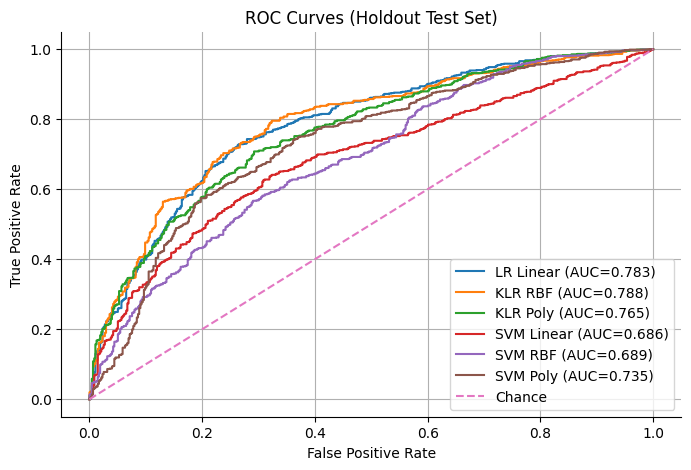

,Model,AUC
1,KLR RBF,0.787621
0,LR Linear,0.783153
2,KLR Poly,0.764625
5,SVM Poly,0.734526
4,SVM RBF,0.688954
3,SVM Linear,0.685926


In [ ]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Helpers: ROC and AUC from scratch
def roc_curve_binary(y_true, scores):
    y = np.asarray(y_true).astype(int)
    s = np.asarray(scores, dtype=float)
    # sort by descending score
    order = np.argsort(-s)
    y = y[order]
    s = s[order]

    P = np.sum(y == 1)
    N = np.sum(y == 0)
    if P == 0 or N == 0:
        raise ValueError("Both classes must be present to compute ROC.")

    # sweep thresholds at each unique score
    tps = 0
    fps = 0
    fpr = [0.0]
    tpr = [0.0]
    # counts of positives/negatives encountered as threshold moves
    for yi in y:
        if yi == 1:
            tps += 1
        else:
            fps += 1
        fpr.append(fps / N)
        tpr.append(tps / P)

    # Ensure proper bounds
    fpr = np.clip(np.array(fpr), 0, 1)
    tpr = np.clip(np.array(tpr), 0, 1)
    # Force start/end anchors
    fpr[0], tpr[0] = 0.0, 0.0
    fpr[-1], tpr[-1] = 1.0, 1.0
    return fpr, tpr

def auc_trapz(fpr, tpr):
    fpr = np.asarray(fpr, dtype=float)
    tpr = np.asarray(tpr, dtype=float)
    # sort by fpr just in case
    order = np.argsort(fpr)
    fpr = fpr[order]; tpr = tpr[order]
    return float(np.trapz(tpr, fpr))

def get_scores(model, X):
    # LR/KLR
    if hasattr(model, "predict_proba"):
        proba = model.predict_proba(X)
        # ensure 1D prob of class 1
        if proba.ndim > 1:
            proba = proba[:, 1]
        return proba
    # SVMs
    if hasattr(model, "decision_function"):
        return model.decision_function(X)
    # Fallback: linear margin if available
    if hasattr(model, "w") and hasattr(model, "b"):
        return X @ model.w + model.b
    raise AttributeError("Model does not expose a scoring method.")

# Prepare preprocessed train/test for this cell
wins_roc = IQRWinsorizer(k=1.5).fit(X_train)
Xtr_w = wins_roc.transform(X_train); Xte_w = wins_roc.transform(X_test)
sc_roc = StandardScaler().fit(Xtr_w)
Xtr = sc_roc.transform(Xtr_w); Xte = sc_roc.transform(Xte_w)

# Build and score best models
names = ["LR Linear", "KLR RBF", "KLR Poly", "SVM Linear", "SVM RBF", "SVM Poly"]
auc_rows = []

plt.figure()
for name in names:
    params = search_summaries[name]["best_params"]
    model = instantiate_model(name, params)
    model.fit(Xtr, y_train)
    scores = get_scores(model, Xte)
    fpr, tpr = roc_curve_binary(y_test, scores)
    auc = auc_trapz(fpr, tpr)
    auc_rows.append({"Model": name, "AUC": auc})
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")

# Diagonal baseline
plt.plot([0,1], [0,1], linestyle="--", label="Chance")

plt.title("ROC Curves (Holdout Test Set)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

auc_df = pd.DataFrame(auc_rows).sort_values("AUC", ascending=False)
auc_df
